## Beautiful Demo

Loads training data and shows an example training face

In [1]:
from matplotlib import pyplot as plt
from read_data import training_validation

from time import time
from random import choice

(training_images, training_labels), (test_images, test_labels) = training_validation()

sample_image_positive = choice(training_images)
sample_image_negative = choice(test_images)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(sample_image_positive)
ax2.imshow(sample_image_negative)
plt.show()



reading csv: 6.3980019092559814
formatting to numpy matrices: 6.802215814590454
picking random data: 0.014042139053344727
Formatting data: 2.09808349609375e-05


## Example of feature selection used

-24487.0
-12211.0
-25243.0
86705.0
91210.0


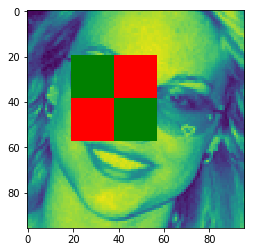

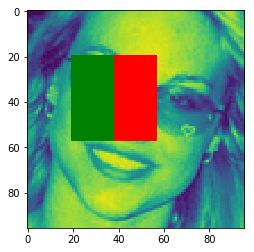

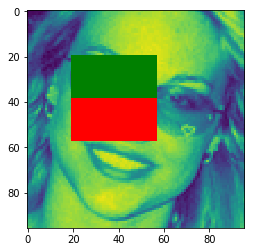

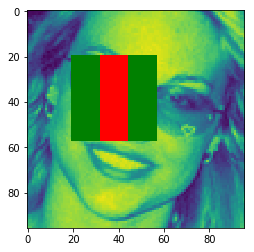

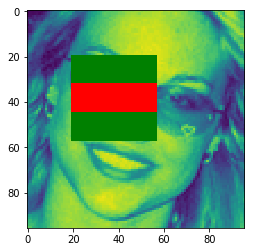

In [2]:
from features import *
from processing import IntegralImage

fsize = FeatureSize(0.2, 0.2, 0.4, 0.4)
ii = IntegralImage(sample_image_positive)
ii.process()

f = Feature(fsize, A)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B1)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B2)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, C1)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, C2)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))


plt.show()

## Example of Feature Generation

In [3]:
from features import *
count = 0
for sz in generate_all_sizes():
    count += 1
print(count)

225


## Format training and test data

The format is adapted for the special ada boosted version, to extract features, therefore to train the normal bayes
we have to transpose the data to get image x features instead of features x images.

In [4]:
import processing
import features
import os
import pickle
from numpy import save, load




outTrain = None
outTest = None

training = None
test = None
IItraining = None
IItest = None
all_features = features.generate_all_features()

if not os.path.isfile("training_feature_matrix.npy"):
    
    print("Stage 1")
    IItraining = processing.bulk_II(training_images)
    IItest = processing.bulk_II(test_images)
    
    outTrain = open('IITraining.pkl', 'wb')
    outTest = open('IITesting.pkl', 'wb')
    pickle.dump(IItraining, outTrain)
    pickle.dump(IItest, outTest)
    outTrain.close()
    outTest.close()
    
    print("Stage 2")
    training = features.get_feature_matrix(IItraining, all_features)
    test = features.get_feature_matrix(IItest, all_features)

    """ _ is same as above. """

    save("training_feature_matrix", training)
    save("test_feature_matrix", test)
else:
    training = load("training_feature_matrix.npy")
    test = load("test_feature_matrix.npy")
    outTrain = open('IITraining.pkl', 'rb')
    outTest = open('IITesting.pkl', 'rb')
    IItraining = pickle.load(outTrain)
    IItest = pickle.load(outTest)
    outTrain.close()
    outTest.close()
    



## Display of Integral Image

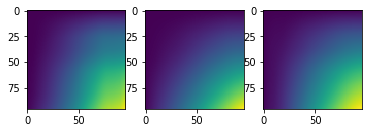

In [5]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(IItraining[0].ii)
ax2.imshow(IItraining[200].ii)
ax3.imshow(IItraining[400].ii)

plt.show()


Hi
Starting training
Round we go!! Currently: 1.0  Target is: 0.05
Round we go!! Currently: 0.10845356831606467  Target is: 0.05
Number of tests:  950sifier with 5 features2
Success rate: 0.9284210526315789
False positives 0.028421052631578948
False negatives 0.0431578947368421


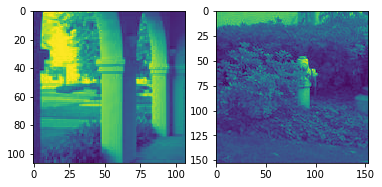

In [6]:
from cascade import cascade
from tests import simple

c = cascade(0.35, 0.7)
print("Hi")
c.train(IItraining, training_labels, 0.05)

p = plt.subplots(1, 2)

simple(c, IItest, test_labels, test_images, p)

plt.show()


## Testing Naive Bayes 

Naive bayes based on Normal distribution

Number of tests:  950
Success rate: 0.8242105263157895
False positives 0.16631578947368422
False negatives 0.009473684210526316


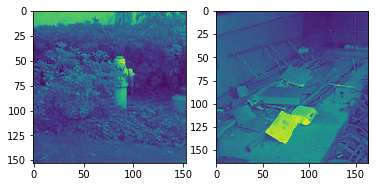

In [7]:
from naive_bayes import naive_bayes
from numpy import array, save
from sys import stdout
from tests import simple

# Bayes is weak when there's to many features.
training_for_bayes = training[500:510].T
test_for_bayes = test[500:510].T


classifier = naive_bayes()
classifier.train(training_for_bayes, training_labels)

p = plt.subplots(1, 2)

simple(classifier, test_for_bayes, test_labels, test_images, p)

plt.show()

## Example of a single feature boosted classifier

A bunch of these are combined in the cascade

Number of tests:  950sifier with 10 features
Success rate: 0.9452631578947368
False positives 0.034736842105263156
False negatives 0.02


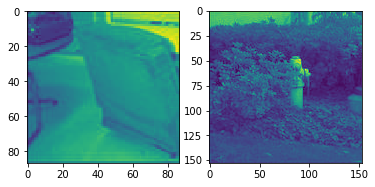

In [8]:
from ada_boost import boosted_classifier
from tests import simple

# Constructor takes num of features
classifier = boosted_classifier(10)
classifier.train(training, all_features, training_labels)
p = plt.subplots(1, 2)

simple(classifier, IItest, test_labels, test_images, p)

plt.show()

